In [8]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [113]:
data = loadmat('ex8data1.mat')
X = data['X']
X_val = data['Xval']
y_val = data['yval'].squeeze().astype('int32')

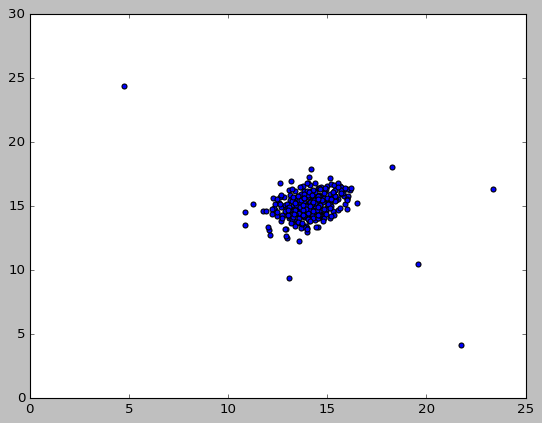

In [114]:
plt.scatter(X[:, 0], X[:, 1])

In [115]:
def estimate_gaussian(X):
    means = np.mean(X, axis=0)
    variances = np.var(X, axis=0)
    
    return (means, variances)

(means, variances) = estimate_gaussian(X)

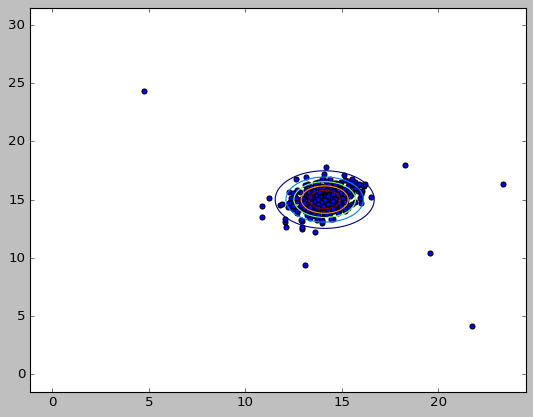

In [116]:
# from https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

def multivariate_gaussian(X, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2 * np.pi) ** n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', X-mu, Sigma_inv, X-mu)

    return np.exp(-fac / 2) / N

def contour_plot(mu, Sigma):
    N = 600
    X = np.linspace(0, 20, N)
    Y = np.linspace(0, 30, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = multivariate_gaussian(pos, mu, Sigma)
    
    plt.contour(X, Y, Z, zdir='z', offset=-0.15)
    
plt.scatter(X[:, 0], X[:, 1])
contour_plot(means, np.diag(variances))

In [117]:
pval = multivariate_gaussian(X_val, means, np.diag(variances))
p = multivariate_gaussian(X, means, np.diag(variances))

# avoid division by 0
E = 0.00000001

def precision(y_true, y_hat):
    tp = np.sum((y_hat == 1) & (y_true == 1))
    fp = np.sum((y_true != y_hat) & (y_true == 0))
    
    return tp / float(tp + fp + E)

def recall(y_true, y_hat):
    tp = np.sum((y_hat == 1) & (y_true == 1))
    fn = np.sum((y_true != y_hat) & (y_true == 1))
    
    return tp / float(tp + fn + E)

def f1_score(y_true, y_hat):
    prec = precision(y_true, y_hat)
    rec = recall(y_true, y_hat)
    return (2.0 * prec * rec) / (prec + rec + E)

def select_threshold(yval, pval):
    best_epsilon = 0
    best_f1 = 0
    step = (np.max(pval) - np.min(pval)) / 1000.0
    for epsilon in np.arange(np.min(pval), np.max(pval), step):
        y_hat = np.int32(pval < epsilon)
        f1 = f1_score(yval, y_hat)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            
    return (best_epsilon, best_f1)

(epsilon, _) = select_threshold(y_val, pval)

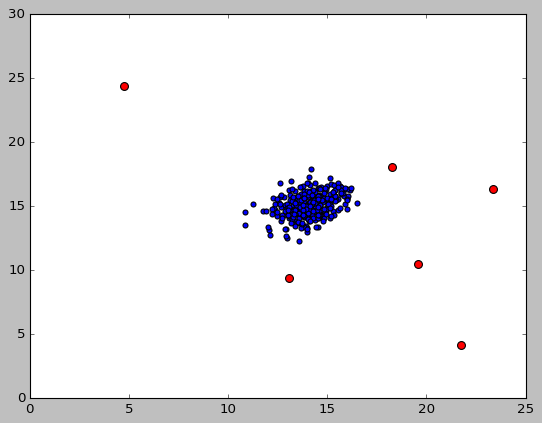

In [118]:
outliers = X[p < epsilon]
plt.scatter(X[:, 0], X[:, 1], c='blue')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', s=50)

In [119]:
data = loadmat('ex8data2.mat')
X = data['X']
X_val = data['Xval']
y_val = data['yval'].squeeze().astype('int32')

(means, variances) = estimate_gaussian(X)
p = multivariate_gaussian(X, means, np.diag(variances))
pval = multivariate_gaussian(X_val, means, np.diag(variances))

(epsilon, f1) = select_threshold(y_val, pval)

print(epsilon, f1)
print(np.sum(p < epsilon))

1.37722889076e-18 0.615384610178
117
